<a href="https://colab.research.google.com/github/dzejkob232/etf/blob/main/etfoptimizer11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
!pip install yfinance
import yfinance as yf
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt


In [36]:

def calculate_returns(data):
    data = data.loc[:, ~data.columns.duplicated()]
    returns = data.pct_change(fill_method=None)
    returns = returns.dropna(how='all')
    return returns

def calculate_ewma_statistics(returns, span=1260):
    # Check if the DataFrame is empty
    if returns.empty:
        raise ValueError("The returns DataFrame is empty. Please check your data.")
    ewma_mean = returns.ewm(span=span).mean().iloc[-1]
    ewma_std = returns.ewm(span=span).std().iloc[-1]
    return ewma_mean, ewma_std

def calculate_ewma_covariance_matrix(returns, span=1260):
    """
    Calculates the EWMA covariance matrix for all ETFs.
    """
    ewm_cov = returns.ewm(span=span).cov()
    # Identify which level of the MultiIndex contains the dates
    level0 = ewm_cov.index.get_level_values(0)
    level1 = ewm_cov.index.get_level_values(1)
    if isinstance(level0[0], pd.Timestamp):
        date_level = 0
    elif isinstance(level1[0], pd.Timestamp):
        date_level = 1
    else:
        raise ValueError("No date level found in ewm_cov index.")
    # Get the last date from the correct index level
    last_date = ewm_cov.index.get_level_values(date_level).max()
    # Extract the covariance matrix corresponding to the last date
    ewma_cov_matrix = ewm_cov.xs(last_date, level=date_level)
    return ewma_cov_matrix



def calculate_sortino_ratio_ewma(returns, annual_rfr=0.04, span=1260):
    daily_rfr = annual_rfr / 252
    ewma_mean = returns.ewm(span=span).mean()
    ewma_downside_std = returns[returns < daily_rfr].ewm(span=span).std()
    expected_returns = ewma_mean.iloc[-1]
    downside_std = ewma_downside_std.iloc[-1]
    sortino_ratios = (expected_returns - daily_rfr) / downside_std
    sortino_ratios = sortino_ratios.replace([np.inf, -np.inf], np.nan).dropna().sort_values(ascending=False)
    return sortino_ratios

def optimize_portfolio_ewma(returns, selected_etfs, annual_rfr, span=1260):
    daily_rfr = annual_rfr / 252
    returns_selected = returns[selected_etfs].dropna(how='any')
    if returns_selected.empty or len(returns_selected) < 2:
        raise ValueError("No overlapping data or insufficient data for selected ETFs.")
    ewma_expected_returns = returns_selected.ewm(span=span).mean().iloc[-1]
    ewm_cov = returns_selected.ewm(span=span).cov().dropna()
    last_date = ewm_cov.index.get_level_values(0).max()
    ewma_cov_matrix = ewm_cov.loc[last_date]
    ewma_cov_matrix = ewma_cov_matrix.loc[selected_etfs, selected_etfs]
    def negative_sharpe_ratio(weights):
        portfolio_return = np.dot(weights, ewma_expected_returns)
        portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(ewma_cov_matrix, weights)))
        sharpe_ratio = (portfolio_return - daily_rfr) / portfolio_std_dev
        return -sharpe_ratio
    n_assets = len(selected_etfs)
    initial_guess = np.array([1 / n_assets] * n_assets)
    bounds = [(0, 1)] * n_assets
    constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
    result = minimize(
        negative_sharpe_ratio,
        initial_guess,
        method='SLSQP',
        bounds=bounds,
        constraints=constraints
    )
    if result.success:
        optimized_weights = result.x
        portfolio_return = np.dot(optimized_weights, ewma_expected_returns)
        portfolio_std_dev = np.sqrt(np.dot(optimized_weights.T, np.dot(ewma_cov_matrix, optimized_weights)))
        sharpe_ratio = (portfolio_return - daily_rfr) / portfolio_std_dev
        portfolio = pd.DataFrame({'ETF': selected_etfs, 'Weight': optimized_weights})
        portfolio['Weight'] = portfolio['Weight'] / portfolio['Weight'].sum()
        return portfolio, portfolio_return, portfolio_std_dev, sharpe_ratio
    else:
        raise ValueError("Optimization failed.")

def plot_ios(portfolios, returns, annual_rfr):
    daily_rfr = annual_rfr / 252
    plt.figure(figsize=(12, 8))
    colors = plt.cm.tab10(np.linspace(0, 1, len(portfolios)))
    max_sharpe = None
    max_sharpe_return = None
    max_sharpe_std_dev = None
    for idx, portfolio_data in enumerate(portfolios):
        portfolio = portfolio_data['Portfolio']
        selected_etfs = portfolio['ETF'].tolist()
        returns_selected = returns[selected_etfs].dropna(how='any')
        if returns_selected.empty or len(returns_selected) < 2:
            print(f"No overlapping data or insufficient data for portfolio {idx+1}. Skipping.")
            continue
        expected_returns = returns_selected.mean()
        cov_matrix_selected = returns_selected.cov()
        num_portfolios = 500
        results = np.zeros((num_portfolios, 3))
        for i in range(num_portfolios):
            weights = np.random.random(len(selected_etfs))
            weights /= np.sum(weights)
            port_return = np.dot(weights, expected_returns)
            port_std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix_selected, weights)))
            sharpe_ratio = (port_return - daily_rfr) / port_std_dev
            results[i] = [port_std_dev, port_return, sharpe_ratio]
            if (max_sharpe is None) or (sharpe_ratio > max_sharpe):
                max_sharpe = sharpe_ratio
                max_sharpe_return = port_return
                max_sharpe_std_dev = port_std_dev
        color = colors[idx % len(colors)]
        label = '+'.join(selected_etfs)
        plt.scatter(results[:, 0], results[:, 1], label=label, color=color, alpha=0.5, s=10)
    plt.scatter(0, daily_rfr, color='black', marker='o', label='Risk-Free Asset', s=50)
    if max_sharpe is not None:
        x_vals = np.linspace(0, max_sharpe_std_dev * 1.5, 100)
        cal_line = daily_rfr + max_sharpe * x_vals
        plt.plot(x_vals, cal_line, color='red', linestyle='--', label='Capital Allocation Line (CAL)')
    plt.title('Investment Opportunity Set (IOS) of Suggested Portfolios')
    plt.xlabel('Portfolio Standard Deviation')
    plt.ylabel('Portfolio Expected Return')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_historical_performance(suggested_portfolios, returns):
    plt.figure(figsize=(12, 8))
    for idx, portfolio_data in enumerate(suggested_portfolios):
        portfolio = portfolio_data['Portfolio']
        selected_etfs = portfolio['ETF'].tolist()
        weights = portfolio['Weight'].values
        returns_selected = returns[selected_etfs].dropna(how='any')
        if returns_selected.empty or len(returns_selected) < 2:
            print(f"No overlapping data or insufficient data for portfolio {idx+1}. Skipping.")
            continue
        portfolio_returns = returns_selected.mul(weights, axis=1).sum(axis=1)
        cumulative_returns = (1 + portfolio_returns).cumprod()
        label = '+'.join(selected_etfs)
        plt.plot(cumulative_returns.index, cumulative_returns.values, label=label)
    plt.title('Historical Performance of Suggested Portfolios')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.grid(True)
    plt.show()




In [44]:
import yfinance as yf
import pandas as pd

def download_etf_data(etf_list, start_date, end_date):
    """
    Downloads adjusted closing price data for a list of ETFs.
    Handles cases where yf.download returns a DataFrame or a Series.
    """
    data = pd.DataFrame()
    for etf in etf_list:
        try:
            print(f"Downloading data for {etf}...")
            etf_data = yf.download(etf, start=start_date, end=end_date)

            # Check if 'Adj Close' exists and get it, otherwise get the first column
            if 'Adj Close' in etf_data.columns:
                etf_data = etf_data['Adj Close']
            else:
                etf_data = etf_data.iloc[:, 0] # Get the first column

            # Rename the Series or DataFrame column
            if isinstance(etf_data, pd.Series):
                etf_data = etf_data.rename(etf)
            elif isinstance(etf_data, pd.DataFrame):
                etf_data = etf_data.rename(columns={etf_data.columns[0]: etf})
            else:
                print(f"Unexpected data type for {etf}: {type(etf_data)}. Skipping.")
                continue

            data = pd.concat([data, etf_data], axis=1)
            print(f"Successfully downloaded data for {etf}")

        except Exception as e:
            print(f"Failed to download data for {etf}: {e}")
            if "No data found" in str(e):
                print(f"Trying with a suffix for {etf}...")
                try:
                    for suffix in ['.L', '.TO', '.DE']:
                        etf_with_suffix = etf + suffix
                        etf_data = yf.download(etf_with_suffix, start=start_date, end=end_date)
                        # (Repeat same renaming and type checking as above)

                        if 'Adj Close' in etf_data.columns:
                            etf_data = etf_data['Adj Close']
                        else:
                            etf_data = etf_data.iloc[:, 0]

                        if isinstance(etf_data, pd.Series):
                            etf_data = etf_data.rename(etf)
                        elif isinstance(etf_data, pd.DataFrame):
                            etf_data = etf_data.rename(columns={etf_data.columns[0]: etf})
                        else:
                            print(f"Unexpected data type for {etf}: {type(etf_data)}. Skipping.")
                            continue

                        data = pd.concat([data, etf_data], axis=1)
                        print(f"Successfully downloaded data for {etf} using suffix {suffix}")
                        break
                except Exception as e2:
                    print(f"Failed to download data for {etf} with suffixes: {e2}")
            else:
                raise e
    data = data.loc[:, ~data.columns.duplicated()]
    return data

In [45]:
print(type(str))


<class 'type'>


In [46]:
start_date = '2019-01-01'
end_date = '2024-11-07'
annual_rfr = 0.06
span = 800
etf_list = ['IYR', 'QQQ', 'SMH', 'EWI', 'IWB', 'AGG', 'ICSU.L', 'KXI', 'IUSG',
            'EWP', 'EFA', 'XSW', 'GREK', 'IJR', 'CSMIB.MI', 'XLF', 'EWY', 'HERG.L',
            'USO', 'XAR', 'EWG', 'BRND.L', 'ONEQ', 'VHYL.L', 'SCHD', 'GXC',
            'EWQ', 'ITA', 'XLP', 'EWC', 'QTEC', 'IUFS.L', 'TUR', '^N225',
            'LTAM.MI', 'VUKG.L', 'SPY', 'EWN', 'XHB', 'FXI', 'RYH', 'SCHA', 'KWEB',
            'EZA', '^RUT', 'QDVE.DE', 'EWA', 'XLY', 'XSD', 'CEBS.DE', 'XLE', 'GDXJ',
            'EGPT', 'FSTA', 'SPY4.DE', 'VWO', 'FUTY', 'VGOV.L', 'SCHB', 'FEUZ.L', 'VGK',
            'NUCG.L', '^STOXX50E', 'EEM', 'FMAT', 'IXG', 'SCHE', 'IHI', 'IEMG', 'HEALL.XC',
            'WLDS.L', 'XLU', 'EWD', 'IWO', 'IUESX', 'VNM', 'XLI', 'IHF', 'INDA', 'SPLG',
            '^IBEX', 'IWN', 'VWRP.L', 'EPHE', 'RCD', 'DFNS.L', 'RXI', 'HEAW.L', 'SCHF',
            'EWU', 'FSEM.L', 'EMLC', 'IDX', 'SCHC', 'EWH', 'XLV', 'EWW', 'WIGG.L', 'IWP',
            'RHS', 'EQQQ.DE', 'WCOS.AS', 'IWF', 'IEV', 'SCHX', 'XME', 'GDX', 'UNG', 'EIS',
            'RSX', 'SGLN.L', 'EWL', 'IWD', 'EWO', 'IWS', 'IVV', 'XLK', 'IXJ', 'SCHG', 'SCHV',
            'XLB', 'EWZ', 'IWR', 'EWJ', 'PSJ', 'THD', 'EMB', 'IJH', 'ECH', 'EWT', 'GSEM.L',
            'IUSV', 'STW.PA', 'IWM', 'XRT', 'ARGT', 'VEA', 'FIDU', 'PKW', 'EPOL', 'XLRE',
            'INRG.MI','CUKX.L','IGUS.L','CPJ1.L','EHYG.L','EEDG.L','EMHG.L','ROLG.L','FXC',
            'IGLT.L','UESD.L','SSLN.L','EMGA.L','ECAR.L','TLT5.L','WTRE','STHS.L','GGRG.L',
            'NATP.L','TLTE','XSOE','GOAI.SW','GSLC','TKN.TO','FSMG.L','CLMP.L','CMDY','KWEB',
            'KLWD.L','WBIO.L','TLT5.L','ARKG','ARKK','ARKW','REUSEM.XC','PSI20.LS','EWQ','^STI','EWA',
            'EWZ','^MXY','REUG', '^FCHI','^NQMAMCN','^DJEG20','XIU.TO','^HSI','000001.SS'
            '^NSEI','IDX','PSEI.PS','XU100.IS','ATX','^EWN-IV','^OMX','^OMXC25','^OMXH25','ESNB.DE',
            '0P0000RRIV.SW','^MERV','VNM','GLD3','TRET.L','HINS.L','HPRO.L','ROLG.L','WCOA','COCO.MI',
            'UGAS.MI','KC=F','3HCL.MI','SPDM.L','CYSE.L','WLDS.L','DLTM.L','LILAK','ALAG.L','LGQM.DE','GGAL',
            'YPFD.BA','PAM','SPY','IKOR',
            'AIR.DE','RHM.DE','LDO.MI','DSY.PA','BA.L','RTX','LMT','HO.PA']
data = download_etf_data(etf_list, start_date, end_date)



[*********************100%***********************]  1 of 1 completed

Successfully downloaded data for IYR



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for QQQ
Successfully downloaded data for SMH


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for EWI
Successfully downloaded data for IWB


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for AGG
Successfully downloaded data for ICSU.L


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Successfully downloaded data for KXI
Successfully downloaded data for IUSG



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for EWP
Successfully downloaded data for EFA


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for XSW
Successfully downloaded data for GREK


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for IJR
Successfully downloaded data for CSMIB.MI


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for XLF
Successfully downloaded data for EWY


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for HERG.L
Successfully downloaded data for USO


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Successfully downloaded data for XAR
Successfully downloaded data for EWG



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Successfully downloaded data for BRND.L



[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for ONEQ
Successfully downloaded data for VHYL.L


[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for SCHD


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for GXC
Successfully downloaded data for EWQ

[*********************100%***********************]  1 of 1 completed



Successfully downloaded data for ITA


[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for XLP


[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for EWC


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for QTEC
Successfully downloaded data for IUFS.L


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for TUR


[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for ^N225
Successfully downloaded data for LTAM.MI


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for VUKG.L
Successfully downloaded data for SPY


[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for EWN


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for XHB


[*********************100%***********************]  1 of 1 completed

Successfully downloaded data for FXI



[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for RYH
Successfully downloaded data for SCHA


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for KWEB
Successfully downloaded data for EZA


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for ^RUT
Successfully downloaded data for QDVE.DE


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Successfully downloaded data for EWA



[*********************100%***********************]  1 of 1 completed

Successfully downloaded data for XLY



[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for XSD
Successfully downloaded data for CEBS.DE


[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for XLE


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for GDXJ
Successfully downloaded data for EGPT


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for FSTA
Successfully downloaded data for SPY4.DE


[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for VWO


[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for FUTY


[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for VGOV.L


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for SCHB
Successfully downloaded data for FEUZ.L


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for VGK
Successfully downloaded data for NUCG.L


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for ^STOXX50E
Successfully downloaded data for EEM


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Successfully downloaded data for FMAT



[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for IXG
Successfully downloaded data for SCHE


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for IHI
Successfully downloaded data for IEMG


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for HEALL.XC
Successfully downloaded data for WLDS.L


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for XLU
Successfully downloaded data for EWD


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for IWO
Successfully downloaded data for IUESX


[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for VNM


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Successfully downloaded data for XLI



[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for IHF
Successfully downloaded data for INDA


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for SPLG
Successfully downloaded data for ^IBEX


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for IWN
Successfully downloaded data for VWRP.L


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Successfully downloaded data for EPHE



[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for RCD
Successfully downloaded data for DFNS.L


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for RXI
Successfully downloaded data for HEAW.L


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for SCHF
Successfully downloaded data for EWU


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for FSEM.L
Successfully downloaded data for EMLC


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for IDX
Successfully downloaded data for SCHC


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for EWH


[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for XLV
Successfully downloaded data for EWW


[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for WIGG.L


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for IWP


[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for RHS
Successfully downloaded data for EQQQ.DE


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Successfully downloaded data for WCOS.AS



[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for IWF
Successfully downloaded data for IEV


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for SCHX


[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for XME
Successfully downloaded data for GDX


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for UNG
Successfully downloaded data for EIS


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Successfully downloaded data for RSX
Successfully downloaded data for SGLN.L



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for EWL
Successfully downloaded data for IWD


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for EWO
Successfully downloaded data for IWS


[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for IVV


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for XLK
Successfully downloaded data for IXJ


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for SCHG


[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for SCHV
Successfully downloaded data for XLB


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for EWZ
Successfully downloaded data for IWR


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for EWJ
Successfully downloaded data for PSJ


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for THD
Successfully downloaded data for EMB


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for IJH


[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for ECH
Successfully downloaded data for EWT


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for GSEM.L


[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for IUSV
Successfully downloaded data for STW.PA


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for IWM
Successfully downloaded data for XRT


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for ARGT
Successfully downloaded data for VEA


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for FIDU
Successfully downloaded data for PKW


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for EPOL


[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for XLRE
Successfully downloaded data for INRG.MI


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for CUKX.L
Successfully downloaded data for IGUS.L


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for CPJ1.L
Successfully downloaded data for EHYG.L


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for EEDG.L


[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for EMHG.L
Successfully downloaded data for ROLG.L


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for FXC
Successfully downloaded data for IGLT.L


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for UESD.L
Successfully downloaded data for SSLN.L


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for EMGA.L
Successfully downloaded data for ECAR.L


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for TLT5.L
Successfully downloaded data for WTRE


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for STHS.L
Successfully downloaded data for GGRG.L


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for NATP.L
Successfully downloaded data for TLTE


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for XSOE
Successfully downloaded data for GOAI.SW


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for GSLC
Successfully downloaded data for TKN.TO


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for FSMG.L
Successfully downloaded data for CLMP.L


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for CMDY


[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for KWEB
Successfully downloaded data for KLWD.L


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for WBIO.L
Successfully downloaded data for TLT5.L


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Successfully downloaded data for ARKG



[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for ARKK


[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for ARKW
Successfully downloaded data for REUSEM.XC


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for PSI20.LS
Successfully downloaded data for EWQ


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for ^STI
Successfully downloaded data for EWA


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for EWZ
Successfully downloaded data for ^MXY


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['REUG']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for REUG
Successfully downloaded data for ^FCHI


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^NQMAMCN']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2019-01-01 -> 2024-11-07)')
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^DJEG20']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2019-01-01 -> 2024-11-07)')


Successfully downloaded data for ^NQMAMCN
Successfully downloaded data for ^DJEG20


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for XIU.TO
Successfully downloaded data for ^HSI


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['000001.SS^NSEI']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed

Successfully downloaded data for 000001.SS^NSEI
Successfully downloaded data for IDX



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for PSEI.PS
Successfully downloaded data for XU100.IS


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['^EWN-IV']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2019-01-01 -> 2024-11-07)')
[*********************100%***********************]  1 of 1 completed

Successfully downloaded data for ATX
Successfully downloaded data for ^EWN-IV



[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for ^OMX
Successfully downloaded data for ^OMXC25


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for ^OMXH25
Successfully downloaded data for ESNB.DE


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for 0P0000RRIV.SW
Successfully downloaded data for ^MERV


[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for VNM


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['GLD3']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for GLD3
Successfully downloaded data for TRET.L


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for HINS.L
Successfully downloaded data for HPRO.L
Successfully downloaded data for ROLG.L


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['WCOA']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for WCOA
Successfully downloaded data for COCO.MI


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for UGAS.MI
Successfully downloaded data for KC=F


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for 3HCL.MI


[*********************100%***********************]  1 of 1 completed

Successfully downloaded data for SPDM.L
Successfully downloaded data for CYSE.L



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for WLDS.L
Successfully downloaded data for DLTM.L


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for LILAK
Successfully downloaded data for ALAG.L


[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for LGQM.DE


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for GGAL
Successfully downloaded data for YPFD.BA


[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for PAM


[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for SPY


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['IKOR']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for IKOR
Successfully downloaded data for AIR.DE


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for RHM.DE
Successfully downloaded data for LDO.MI


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for DSY.PA
Successfully downloaded data for BA.L


[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for RTX


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Successfully downloaded data for LMT
Successfully downloaded data for HO.PA


In [47]:
excluded_etfs = ['REUS.L','UESD.L','TLT','REUSEM.XC','HEALL.XC','ARGT','EGPT','GGAL','COCO.MI']  # Replace with ETFs you want to exclude
data = data.drop(columns=excluded_etfs, errors='ignore')

In [48]:
returns = calculate_returns(data)
ewma_expected_returns, ewma_std_devs = calculate_ewma_statistics(returns, span=1260)
ewma_cov_matrix = calculate_ewma_covariance_matrix(returns, span=1260)
sortino_ratios = calculate_sortino_ratio_ewma(returns, annual_rfr, span=1260)
print("Sortino Ratios (EWMA):")
print(sortino_ratios.head(10))

# Selection of ETFs

# 9 best Sortino ratios tagged as 'best'
best_etfs = sortino_ratios.head(16).index.tolist()
etf_tags = {etf: 'best' for etf in best_etfs}

# 4 highest expected returns (excluding already selected), tagged as 'earn'
remaining_etfs = ewma_expected_returns.drop(index=best_etfs)
top_er_etfs = remaining_etfs.sort_values(ascending=False).head(4).index.tolist()
for etf in top_er_etfs:
    etf_tags[etf] = 'earn'

# Combine selected ETFs
selected_etfs = best_etfs + top_er_etfs
used_etfs = set(selected_etfs)

# For each selected ETF, find ETFs according to specified criteria
for etf in best_etfs + top_er_etfs:
    # Find lowest covariance pair (tagged 'hedge')
    remaining = set(returns.columns) - used_etfs
    if not remaining:
        break
    cov_series = ewma_cov_matrix.loc[etf, list(remaining)].dropna()
    if cov_series.empty:
        continue
    hedge_etf = cov_series.idxmin()
    selected_etfs.append(hedge_etf)
    etf_tags[hedge_etf] = 'hedge'
    used_etfs.add(hedge_etf)

    # Find lowest covariance ETF with e(r) > risk-free rate (tagged 'mid')
    er_filtered = ewma_expected_returns[list(remaining)]
    er_filtered = er_filtered[er_filtered > annual_rfr / 252]
    if not er_filtered.empty:
        cov_series_er = ewma_cov_matrix.loc[etf, er_filtered.index].dropna()
        if not cov_series_er.empty:
            mid_etf = cov_series_er.idxmin()
            selected_etfs.append(mid_etf)
            etf_tags[mid_etf] = 'mid'
            used_etfs.add(mid_etf)

    # Find lowest covariance ETF from top 20% Sortino ratio (tagged 'high')
    sortino_top_20 = sortino_ratios.head(int(len(sortino_ratios) * 0.2))
    remaining_high = set(sortino_top_20.index) - used_etfs
    if remaining_high:
        cov_series_high = ewma_cov_matrix.loc[etf, list(remaining_high)].dropna()
        if not cov_series_high.empty:
            high_etf = cov_series_high.idxmin()
            selected_etfs.append(high_etf)
            etf_tags[high_etf] = 'high'
            used_etfs.add(high_etf)

print("\nSelected ETFs and their tags:")
for etf in selected_etfs:
    print(f"{etf}: {etf_tags.get(etf, 'unlabeled')}")

selected_etfs = list(used_etfs)
print("\nFinal list of candidate ETFs:")
print(selected_etfs)

# Check overlapping data
returns_selected = returns[selected_etfs].dropna()
if len(returns_selected) < 200:
    print("\nInsufficient overlapping data for selected ETFs.")
    # Optionally, implement logic to exclude problematic ETFs and select replacements
else:
    print("\nSufficient overlapping data for selected ETFs.")


Sortino Ratios (EWMA):
Ticker
DFNS.L     0.219735
GOAI.SW    0.202506
NATP.L     0.182951
^MERV      0.178461
YPFD.BA    0.166336
EHYG.L     0.116275
SMH        0.100788
RHM.DE     0.100608
XHB        0.093650
QDVE.DE    0.093634
Name: 2024-11-06 00:00:00+00:00, dtype: float64

Selected ETFs and their tags:
DFNS.L: best
GOAI.SW: best
NATP.L: best
^MERV: best
YPFD.BA: best
EHYG.L: best
SMH: best
RHM.DE: best
XHB: best
QDVE.DE: best
FIDU: best
LDO.MI: best
XLI: best
XLK: best
SCHD: best
SCHG: best
PAM: earn
TKN.TO: earn
XME: earn
XU100.IS: earn
FSMG.L: hedge
ICSU.L: mid
SCHV: high
TLT5.L: hedge
RTX: mid
ITA: high
3HCL.MI: mid
3HCL.MI: mid
IUSV: high
SGLN.L: mid
SGLN.L: mid
BA.L: high
VGOV.L: hedge
KC=F: mid
EQQQ.DE: high
ESNB.DE: hedge
LMT: mid
IVV: high
IGLT.L: hedge
PSEI.PS: mid
SPY4.DE: high
RSX: hedge
XLP: mid
GSLC: high
ROLG.L: hedge
^STI: mid
SPY: high
AGG: hedge
SSLN.L: mid
IXG: high
FSEM.L: hedge
STHS.L: mid
SPLG: high
FXC: hedge
GDX: mid
QQQ: high
^HSI: hedge
WCOS.AS: mid
SCHX: 

In [49]:
# Calculate the number of non-NaN entries for each selected ETF
data_coverage = data[selected_etfs].notna().sum().sort_values()

print("Data Coverage for Each Selected ETF:")
print(data_coverage)


Data Coverage for Each Selected ETF:
Ticker
GOAI.SW     248
NATP.L      343
TLT5.L      378
EHYG.L      387
DFNS.L      405
           ... 
3HCL.MI    1491
RHM.DE     1491
WCOS.AS    1501
STW.PA     1502
HO.PA      1502
Length: 74, dtype: int64


In [50]:
print(data.isna().sum())


Ticker
IYR       50
QQQ       50
SMH       50
EWI       50
IWB       50
          ..
DSY.PA    21
BA.L      45
RTX       50
LMT       50
HO.PA     21
Length: 214, dtype: int64


In [51]:
try:
    portfolio, port_return, port_std_dev, sharpe_ratio = optimize_portfolio_ewma(
        returns, selected_etfs, annual_rfr, span=1260)
    portfolio['Weight'] = portfolio['Weight'].apply(lambda x: round(x, 3))
    print("\nOptimized Portfolio:")
    print(portfolio)
    print(f"Expected Return: {port_return:.5f}, Std Dev: {port_std_dev:.5f}, Sharpe Ratio: {sharpe_ratio:.5f}")
    suggested_portfolios = [{
        'Portfolio': portfolio,
        'Returns': [port_return],
        'StdDevs': [port_std_dev],
        'SharpeRatio': sharpe_ratio
    }]
except ValueError as e:
    print(f"Optimization failed: {e}")



Optimized Portfolio:
      ETF  Weight
0     IWF   0.000
1    SCHD   0.000
2    SCHG   0.121
3   HO.PA   0.000
4     XHB   0.000
..    ...     ...
69    USO   0.000
70  ^MERV   0.019
71   GSLC   0.000
72   ^STI   0.000
73   IUSV   0.000

[74 rows x 2 columns]
Expected Return: 0.00175, Std Dev: 0.00297, Sharpe Ratio: 0.51001


In [52]:
try:
    portfolio, port_return, port_std_dev, sharpe_ratio = optimize_portfolio_ewma(
        returns, selected_etfs, annual_rfr, span=1260)
    portfolio['Weight'] = portfolio['Weight'].apply(lambda x: round(x, 3))

    # Filter out ETFs with weight approximately 0
    filtered_portfolio = portfolio[portfolio['Weight'] > 0]

    print("\\nOptimized Portfolio:")
    print(filtered_portfolio)
    print(f"Expected Return: {port_return:.5f}, Std Dev: {port_std_dev:.5f}, Sharpe Ratio: {sharpe_ratio:.5f}")
    suggested_portfolios = [{
        'Portfolio': filtered_portfolio,
        'Returns': [port_return],
        'StdDevs': [port_std_dev],
        'SharpeRatio': sharpe_ratio
    }]
except ValueError as e:
    print(f"Optimization failed: {e}")

\nOptimized Portfolio:
        ETF  Weight
2      SCHG   0.121
5    TKN.TO   0.040
18  SPY4.DE   0.003
19   STHS.L   0.077
20   ICSU.L   0.093
22   SGLN.L   0.183
27   RHM.DE   0.015
33      XLF   0.052
35      RTX   0.120
43   DFNS.L   0.004
45   FSEM.L   0.189
52  PSEI.PS   0.062
66   EHYG.L   0.008
67      ITA   0.013
70    ^MERV   0.019
Expected Return: 0.00175, Std Dev: 0.00297, Sharpe Ratio: 0.51001


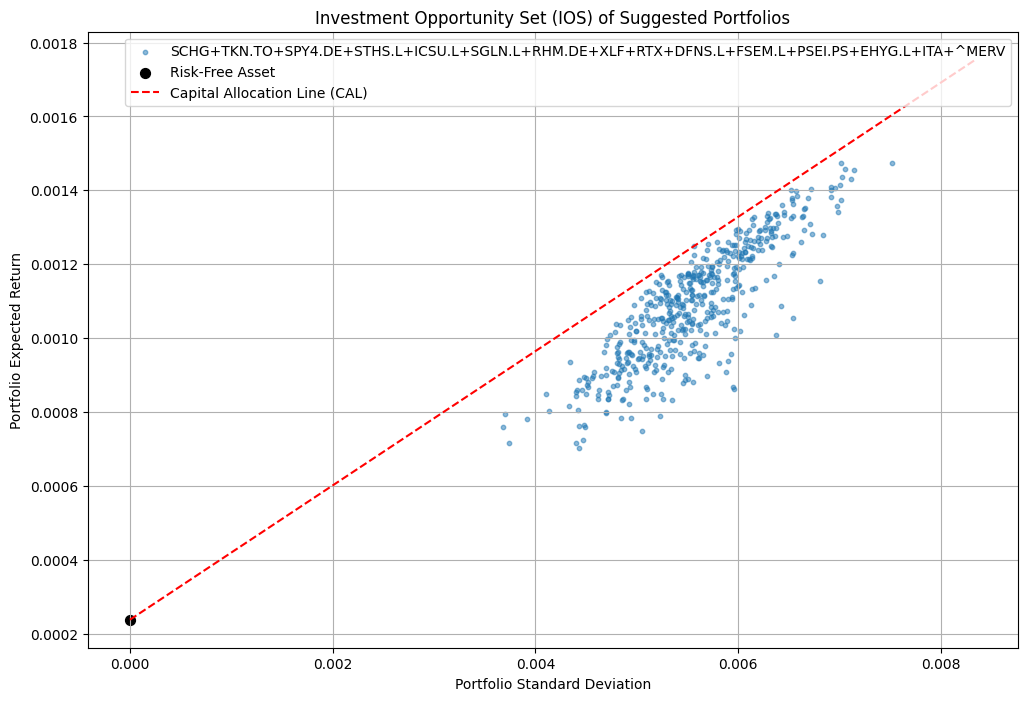

In [53]:
plot_ios(suggested_portfolios, returns, annual_rfr)


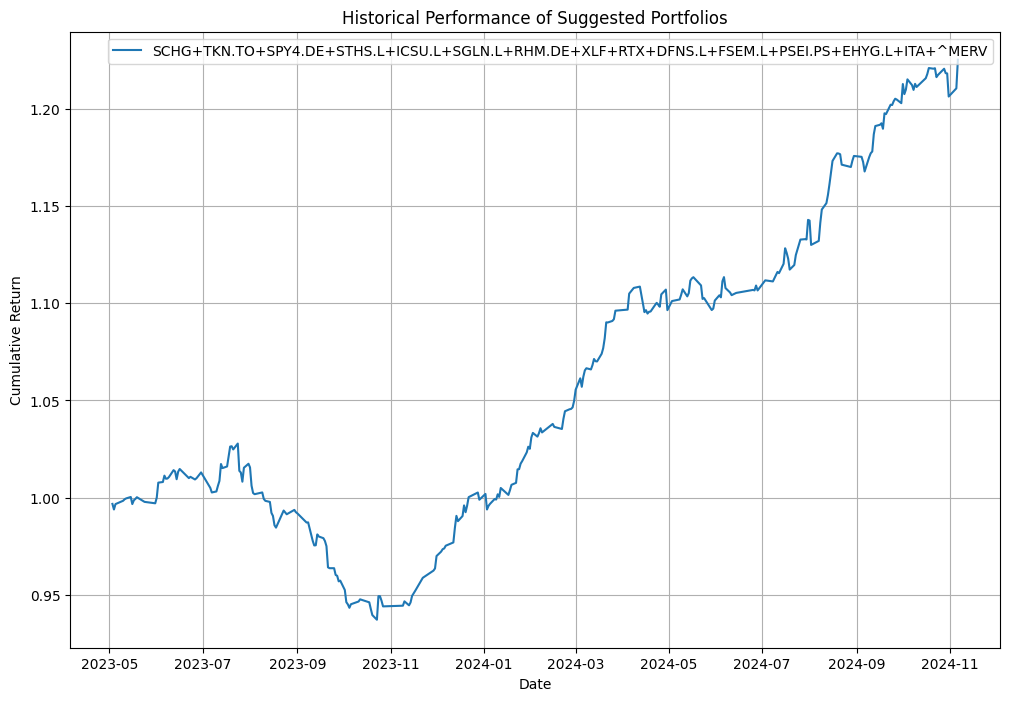

In [54]:
plot_historical_performance(suggested_portfolios, returns)


In [58]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize

def expand_portfolio(base_portfolio, returns, min_base_weight=0.5, annual_rfr=0.06, span=1260):
    """
    Composes an optimal portfolio expansion using the base portfolio as a required component.

    Args:
    - base_portfolio (dict): A dictionary with tickers as keys and weights as values.
    - returns (pd.DataFrame): DataFrame containing returns for all available tickers.
    - min_base_weight (float): The minimum weight of the base portfolio in the final result (0 < min_base_weight < 1).
    - annual_rfr (float): Annual risk-free rate (default is 0.06).
    - span (int): Span for the EWMA calculations (default is 1260).

    Returns:
    - pd.DataFrame: DataFrame with the optimized weights for the expanded portfolio.
    - float: Expected return of the expanded portfolio.
    - float: Standard deviation of the expanded portfolio.
    - float: Sharpe ratio of the expanded portfolio.
    """
    if not (0 < min_base_weight < 1):
        raise ValueError("min_base_weight must be between 0 and 1.")

    # 1. Check if base portfolio tickers are in returns DataFrame
    base_tickers = list(base_portfolio.keys())
    missing_base_tickers = [ticker for ticker in base_tickers if ticker not in returns.columns]
    if missing_base_tickers:
        raise ValueError(f"The following tickers from the base portfolio are missing in the 'returns' DataFrame: {missing_base_tickers}")

    # 2. Get tickers for expansion (all downloaded tickers not in base portfolio)
    all_downloaded_tickers = returns.columns.tolist()
    expansion_tickers = [ticker for ticker in all_downloaded_tickers if ticker not in base_tickers]

    if not expansion_tickers:
        raise ValueError("No additional tickers available for expansion (all downloaded tickers are already in the base portfolio).")

    # 3. Prepare data for optimization
    base_weights = np.array(list(base_portfolio.values()))
    base_weights /= base_weights.sum()  # Normalize base weights

    returns_base = returns[base_tickers].dropna(how='any')  # Returns for base portfolio
    returns_expansion = returns[expansion_tickers].dropna(how='any') # Returns for expansion tickers

    ewma_expected_returns = returns_base.ewm(span=span).mean().iloc[-1] #Expected returns for base portfolio

    # Assuming ewma_cov_matrix is calculated for all assets and not just base assets
    ewma_cov_matrix = returns[base_tickers + expansion_tickers].ewm(span=span).cov().xs(returns.index[-1], level=0) # Covariance matrix of base and expansion portfolio

    # 4. Define optimization function
    def negative_sharpe_ratio(weights):
        # Combine base and expansion weights
        combined_weights = np.hstack((min_base_weight * base_weights, (1 - min_base_weight) * weights))
        #Get expected returns of combined portfolio (base + expansion)
        portfolio_return = np.dot(combined_weights, ewma_expected_returns.append(returns_expansion.ewm(span=span).mean().iloc[-1]))
        #Get std deviation of combined portfolio (base + expansion)
        portfolio_std_dev = np.sqrt(np.dot(combined_weights.T, np.dot(ewma_cov_matrix, combined_weights)))
        sharpe_ratio = (portfolio_return - (annual_rfr / 252)) / portfolio_std_dev
        return -sharpe_ratio

    # 5. Perform optimization
    initial_guess = np.array([1 / len(expansion_tickers)] * len(expansion_tickers))
    bounds = [(0, 1)] * len(expansion_tickers)
    constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}

    result = minimize(

SyntaxError: incomplete input (<ipython-input-58-ee5f1620b74d>, line 66)

In [59]:
expand_portfolio({'AIR.DE':0.125,'RHM.DE':0.125,'LDO.MI':0.125,'DSY.PA':0.125,'BA.L':0.125,'RTX':0.125,'LMT':0.125,'HO.PA':0.125})

ValueError: No additional tickers available for expansion.